In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# Size of input images
SIZE = 128




## Define generators for training, validation and also anomaly data.

In [4]:
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/chest_xray/val/NORMAL/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 1341 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
Found 390 images belonging to 1 classes.





# Define the autoencoder.
## Try to make the bottleneck layer size as small as possible to make it easy for

## density calculations and also picking appropriate thresholds

In [5]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

In [6]:
#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0

# Fit the model

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/1000
7/7 [==============================] - 175s 23s/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 2/1000
7/7 [==============================] - 123s 15s/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 3/1000
7/7 [==============================] - 67s 9s/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 4/1000
7/7 [==============================] - 44s 6s/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 5/1000
7/7 [==============================] - 42s 4s/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6/1000
7/7 [==============================] - 25s 4s/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 7/1000
7/7 [==============================] - 16s 2s/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 8/1000
7/7 [==============================] - 14s 2s/step - loss: 0.0089 - mse: 

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/best_weights_anomaly/best_weights_anomaly.h5')




# Plot the training and validation accuracy and loss at each epoch

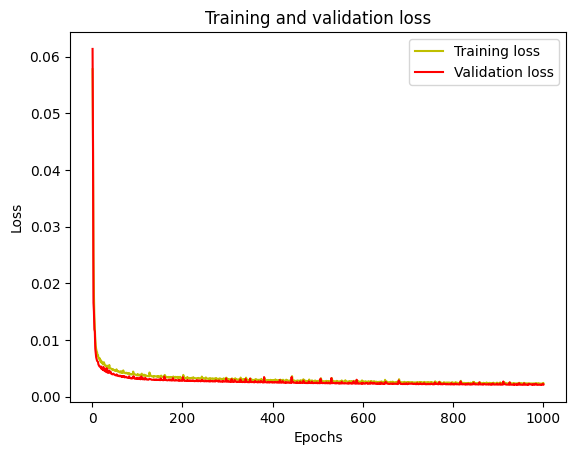

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Load the saved weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/best_weights_anomaly/best_weights_anomaly.h5')

# Get all batches generated by the datagen and pick a batch for prediction just to test the model

In [10]:
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images

2/2 [==============================] - 3s 6ms/step


# Sanity check, view few images and corresponding reconstructions

To check the reconstruction performance, run the code snippet below a few times. Each run demonstrates a reconstruction of a random image

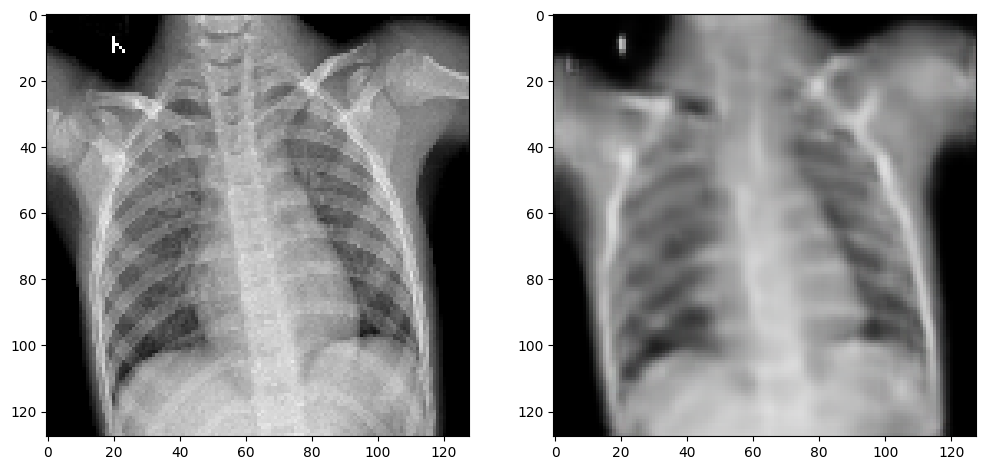

In [11]:
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

# Let us examine the reconstruction error between our validation data (good/normal images) and anomaly images

In [ ]:
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

<ipython-input-25-e39292c457be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)
<ipython-input-25-e39292c457be>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.0021145623177289963, 0.0021145623177289963]
Recon. error for the anomaly data is:  [0.0018464414170011878, 0.0018464414170011878]


# Extract (or build) the encoder network, with trained weights.
# This is used to get the compressed output (latent space) of the input image.
# The compressed output is then used to calculate the KDE

In [12]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 16)       

In [13]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

<ipython-input-13-bd7cf74ec2f6>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


#Calculate density and reconstruction error to find their means values for
#good and anomaly images.
#We use these mean and sigma to set thresholds

In [14]:
def calc_density_and_recon_error(batch_images):

    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):

        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_density, stdev_density, average_recon_error, stdev_recon_error

#Get average and std dev. of density and recon. error for NORMAL and anomaly (PNEUMOINIA) images.
#For this let us generate a batch of images for each.

In [ ]:
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 26ms/step - loss: 0.0045 - mse: 0.0045


#Now, input unknown images and sort as Good or Anomaly

In [15]:
def check_anomaly(img_path):
    density_threshold = 2500
    reconstruction_error_threshold = 0.004
    img = Image.open(img_path).convert('RGB')  # Convert to RGB
    img = np.array(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, ...]  # Add batch dimension
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1)[0]
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("This sample is PNEUMONIA")
    else:
        print("This sample is NORMAL")

#Testing the model

## To test the model, just replace `image_path` with a path of an image and run the code

<ipython-input-15-ca8745de236c>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128, 128), Image.ANTIALIAS))


1/1 [==============================] - 1s 630ms/step - loss: 0.0015 - mse: 0.0015
This sample is PNEUMONIA


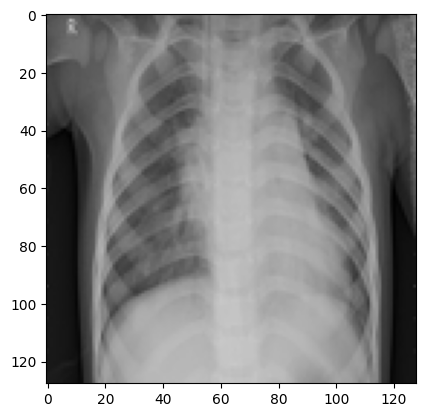

In [16]:
image_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA/Images/person137_bacteria_655.jpeg'

check_anomaly(image_path)